In [3]:
%pip install yfinance pmdarima

Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


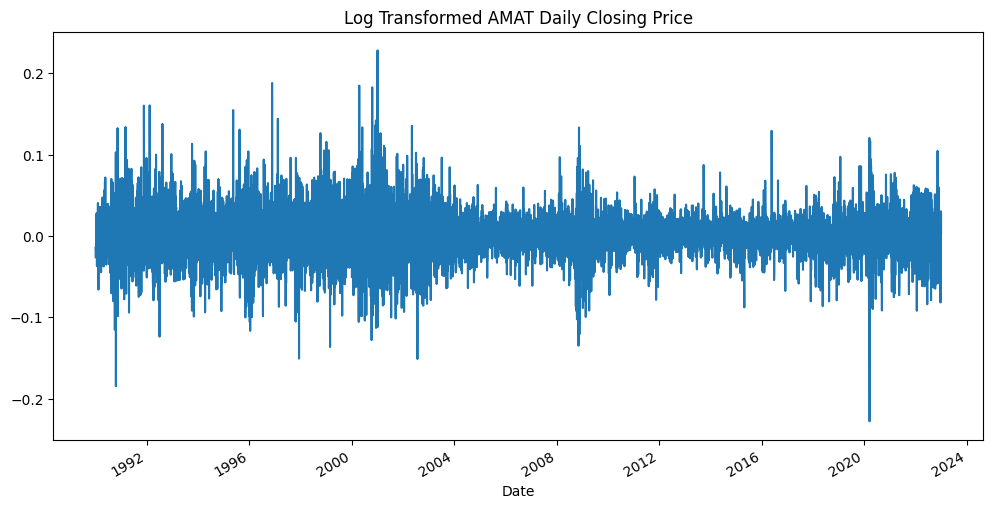

 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-19489.672, Time=0.55 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=-19488.834, Time=0.53 sec
 ARIMA(0,0,0)(0,0,2)[5] intercept   : AIC=-19488.305, Time=2.24 sec
 ARIMA(0,0,0)(1,0,0)[5] intercept   : AIC=-19488.797, Time=0.52 sec
 ARIMA(0,0,0)(1,0,1)[5] intercept   : AIC=-19487.481, Time=1.13 sec
 ARIMA(0,0,0)(1,0,2)[5] intercept   : AIC=-19486.462, Time=1.09 sec
 ARIMA(0,0,0)(2,0,0)[5] intercept   : AIC=-19488.319, Time=1.83 sec
 ARIMA(0,0,0)(2,0,1)[5] intercept   : AIC=-19486.616, Time=3.99 sec
 ARIMA(0,0,0)(2,0,2)[5] intercept   : AIC=-19484.557, Time=2.04 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=-19491.764, Time=0.77 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=-19490.886, Time=1.19 sec
 ARIMA(0,0,1)(0,0,2)[5] intercept   : AIC=-19490.329, Time=1.89 sec
 ARIMA(0,0,1)(1,0,0)[5] intercept   : AIC=-19490.847, Time=0.44 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=-19489.503, Time=1.09 sec
 ARIMA(0,0,1)(1,0,2)[5] intercept   : AIC=-19488

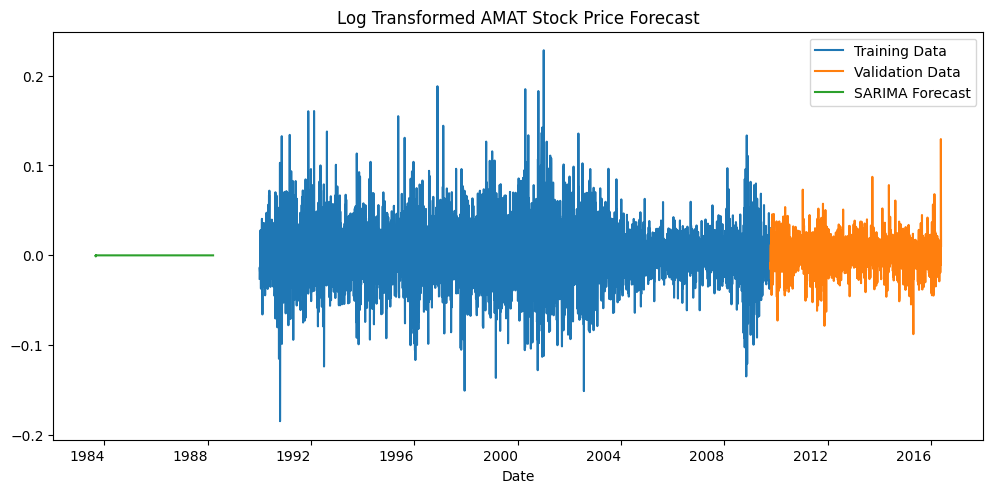

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Download data
data = yf.download("AMAT", start="1990-01-01", end="2023-01-01")
daily_close = data['Close'].dropna()

# Log transformation
daily_close_log = np.log(daily_close)

# ADF test for stationarity
result = adfuller(daily_close_log)
if result[1] > 0.05:
    daily_close_log = daily_close_log.diff().dropna()

plt.figure(figsize=(12,6))
daily_close_log.plot(title='Log Transformed AMAT Daily Closing Price')
plt.show()

# Split data
train_size = int(0.6 * len(daily_close_log))
val_size = int(0.2 * len(daily_close_log))
train = daily_close_log[:train_size]
val = daily_close_log[train_size:train_size+val_size]
test = daily_close_log[train_size+val_size:]

# auto_arima with wider range of parameters
model = auto_arima(train, seasonal=True, m=5, trace=True, error_action='ignore', suppress_warnings=True,
                   start_p=0, start_q=0, max_p=5, max_q=5, stepwise=False, seasonal_test='ocsb', 
                   max_order=None, d=None, max_d=2, D=None, max_D=1, trend='c')

model.summary()

sarima_model = SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order)
sarima_result = sarima_model.fit()

forecast = sarima_result.predict(start=len(train), end=len(train)+len(val)-1, dynamic=False)

plt.figure(figsize=(12,6))
train.plot(label='Training Data')
val.plot(label='Validation Data')
forecast.plot(label='SARIMA Forecast')
plt.legend(loc='best')
plt.title('Log Transformed AMAT Stock Price Forecast')
plt.show()
